<a href="https://colab.research.google.com/github/ewboyeff/AI-speacial/blob/main/Keylogger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Kerakli kutubxonalar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 2. Kaggle API ni sozlash
print("Kaggle API ni sozlash...")
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_api = {
    "username": "dilshod2006",
    "key": "9b2b91cc9ba512a5e79836df40738c5b"
}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(kaggle_api, file)
!chmod 600 /root/.kaggle/kaggle.json

Kaggle API ni sozlash...


In [11]:
# 3. Ma'lumotlarni yuklash
print("Ma'lumotlarni yuklash...")
try:
    !kaggle datasets download -d subhajournal/keylogger-detection -p /content --unzip
    dataset = pd.read_csv("/content/Keylogger_Detection.csv")
except Exception as e:
    raise Exception(f"Ma'lumotlarni yuklashda xatolik: {e}. Iltimos, Kaggle API kaliti to'g'ri ekanligini va internet aloqasini tekshiring.")

Ma'lumotlarni yuklash...
Dataset URL: https://www.kaggle.com/datasets/subhajournal/keylogger-detection
License(s): GNU Free Documentation License 1.3
  0% 0.00/79.4M [00:00<?, ?B/s]
100% 79.4M/79.4M [00:00<00:00, 1.32GB/s]


In [12]:
df = dataset.copy()
# Keraksiz ustunlarni o'chirish
drop_columns = ['Unnamed: 0', 'Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')
df = df.dropna().drop_duplicates().reset_index(drop=True)

In [13]:
# Manfiy qiymatlarni to'g'rilash
non_neg_cols = [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets']
for col in non_neg_cols:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

In [14]:
# 5. Target encoding
le = LabelEncoder()
if 'Class' in df.columns:
    df['Class'] = le.fit_transform(df['Class'])
    print(f"Sinflar: {le.classes_}")
else:
    raise KeyError("Datasetda 'Class' ustuni topilmadi.")

Sinflar: ['Benign' 'Keylogger']


In [15]:
# 6. Yangi xususiyatlar yaratish
# Ustun nomlarini datasetga moslashtirish
fwd_packets_col = 'Total Length of Fwd Packets'
bwd_packets_col = ' Total Length of Bwd Packets'
if fwd_packets_col in df.columns and bwd_packets_col in df.columns:
    df['packet_ratio'] = (df[' Total Fwd Packets'] + 1) / (df[' Total Backward Packets'] + 1)
    df['byte_ratio'] = (df[fwd_packets_col] + 1) / (df[bwd_packets_col] + 1)
else:
    print(f"Xatolik: {fwd_packets_col} yoki {bwd_packets_col} ustunlari topilmadi. Yangi xususiyatlar yaratilmadi.")

In [16]:
# 7. Ma'lumotlarni bo'lish
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101, stratify=y)

In [17]:
# 8. Muvozanatlash (undersampling)
rus = RandomUnderSampler(random_state=101)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
print(f"Muvozanatlashdan keyin sinf taqsimoti: {np.bincount(y_train_bal)}")

Muvozanatlashdan keyin sinf taqsimoti: [62137 62137]


In [18]:
# 9. Xususiyatlarni tanlash
selector = SelectKBest(score_func=f_classif, k=25)
X_train_sel = selector.fit_transform(X_train_bal, y_train_bal)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()].tolist()
print(f"Tanlangan xususiyatlar: {selected_features}")

Tanlangan xususiyatlar: [' Flow Duration', ' Fwd Packet Length Max', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Flow IAT Std', ' Flow IAT Max', ' Fwd IAT Std', 'Bwd IAT Total', ' Bwd IAT Std', ' Bwd IAT Max', ' Max Packet Length', ' Packet Length Std', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' Avg Fwd Segment Size', 'Init_Win_bytes_forward', 'Active Mean', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Max', ' Idle Min']


In [19]:
# 10. O'lchovlash
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

In [20]:
# 11. XGBoost modeli
print("\nXGBoost modelini o'qitish...")
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=101, n_jobs=-1)
xgb.fit(X_train_scaled, y_train_bal)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost natijalari:")
print(classification_report(y_test, y_pred_xgb))


XGBoost modelini o'qitish...

XGBoost natijalari:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     29825
           1       0.57      0.64      0.60     20713

    accuracy                           0.66     50538
   macro avg       0.65      0.65      0.65     50538
weighted avg       0.66      0.66      0.66     50538



In [21]:
# 12. Deep Learning modeli
print("\nChuqur o'rganish modelini o'qitish...")
def create_dl_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dl_model = create_dl_model(X_train_scaled.shape[1])
dl_model.fit(
    X_train_scaled, y_train_bal,
    epochs=50, batch_size=32, validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

y_pred_proba_dl = dl_model.predict(X_test_scaled, verbose=0)
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int).flatten()

print("\nDeep Learning natijalari:")
print(classification_report(y_test, y_pred_dl))


Chuqur o'rganish modelini o'qitish...

Deep Learning natijalari:
              precision    recall  f1-score   support

           0       0.60      0.97      0.74     29825
           1       0.63      0.06      0.12     20713

    accuracy                           0.60     50538
   macro avg       0.62      0.52      0.43     50538
weighted avg       0.61      0.60      0.49     50538



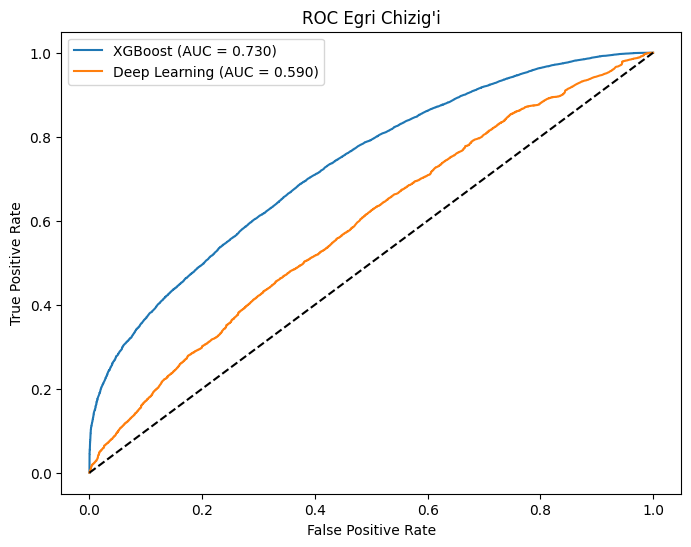

In [22]:
# 13. ROC egri chizig'i
plt.figure(figsize=(8, 6))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_proba_dl)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.3f})')
plt.plot(fpr_dl, tpr_dl, label=f'Deep Learning (AUC = {auc(fpr_dl, tpr_dl):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Egri Chizig\'i')
plt.legend()
plt.savefig('roc_curve.png')

In [23]:
# 14. Eng yaxshi modelni saqlash
best_auc = max(auc(fpr_xgb, tpr_xgb), auc(fpr_dl, tpr_dl))
if best_auc == auc(fpr_xgb, tpr_xgb):
    import joblib
    joblib.dump(xgb, 'keylogger_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selected_features, 'features.pkl')
    print("XGBoost eng yaxshi model sifatida saqlandi")
else:
    dl_model.save('keylogger_model.h5')
    import joblib
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(selected_features, 'features.pkl')
    print("Deep Learning eng yaxshi model sifatida saqlandi")

print("Dastur muvaffaqiyatli yakunlandi!")

XGBoost eng yaxshi model sifatida saqlandi
Dastur muvaffaqiyatli yakunlandi!


In [24]:
from google.colab import files
files.download('roc_curve.png')
files.download('keylogger_model.pkl')  # yoki keylogger_model.h5
files.download('scaler.pkl')
files.download('features.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>